In [19]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [20]:
# Cargar el archivo CSV
df = pd.read_csv('bitcoin.csv')

# Mostrar las primeras filas del DataFrame
df.head()

,Fecha,Último,Apertura,Máximo,Mínimo,Vol.,% var.
0,18.02.2025,"95.638,0","95.781,5","96.645,1","93.403,4","74,09K",-0.15%
1,17.02.2025,"95.781,3","96.120,2","97.002,3","95.222,0","58,40K",-0.36%
2,16.02.2025,"96.132,1","97.573,1","97.706,5","96.060,2","33,35K",-1.48%
3,15.02.2025,"97.573,4","97.504,4","97.973,2","97.210,8","29,65K",+0.07%
4,14.02.2025,"97.504,6","96.611,6","98.817,3","96.316,5","65,37K",+0.93%


In [21]:
# Fijar la semilla para reproducibilidad
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [22]:
# Replace commas with dots and convert columns to float
columns_to_convert = ['Último', 'Apertura', 'Máximo', 'Mínimo']
for column in columns_to_convert:
    df[column] = df[column].str.replace('.', '', regex=False).str.replace(',', '.').astype(float)

In [23]:
# Calcular el precio medio
df['Precio_Medio'] = (df['Máximo'] + df['Mínimo']) / 2

# Ordenar los datos por fecha (si no lo están ya)
df['Fecha'] = pd.to_datetime(df['Fecha'], dayfirst=True)
df = df.sort_values('Fecha')

# Utilizamos solo la columna del precio medio
data = df['Precio_Medio'].values.reshape(-1,1)

In [24]:
# Ordenar los datos por fecha (si no lo están ya)
df['Fecha'] = pd.to_datetime(df['Fecha'], dayfirst=True)
df = df.sort_values('Fecha')

In [25]:
# Utilizamos solo la columna del precio medio
data = df['Precio_Medio'].values.reshape(-1,1)

In [26]:
# Escalado de datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [27]:
# Crear secuencias para el entrenamiento
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)

# Probar con distintos tamaños de ventana (por ejemplo, 3, 5, 7)
n_steps = 5  # puedes iterar probando distintos valores
X, y = create_sequences(scaled_data, n_steps)

# Dividir en entrenamiento y test (por ejemplo, 80-20)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [28]:
# Modelo Secuencial con LSTM o GRU
def build_sequential_model(model_type='LSTM', n_steps=5, n_features=1, n_units=50, n_layers=1, optimizer='rmsprop'):
    model = Sequential()
    # Agregar la primera capa con la especificación de input_shape
    if model_type == 'LSTM':
        model.add(LSTM(n_units, return_sequences=(n_layers > 1), input_shape=(n_steps, n_features)))
    elif model_type == 'GRU':
        model.add(GRU(n_units, return_sequences=(n_layers > 1), input_shape=(n_steps, n_features)))
    else:
        raise ValueError("Tipo de modelo no soportado")
    
    # Agregar capas ocultas adicionales, si se especifica
    for _ in range(n_layers - 1):
        if model_type == 'LSTM':
            model.add(LSTM(n_units, return_sequences=True))
        else:
            model.add(GRU(n_units, return_sequences=True))
        model.add(Dropout(0.2))  # opción para regularizar

    # Capa final de salida
    model.add(Dense(1))
    
    # Seleccionar optimizador
    if optimizer.lower() == 'rmsprop':
        opt = RMSprop()
    elif optimizer.lower() == 'adam':
        opt = Adam()
    else:
        raise ValueError("Optimizador no soportado")
        
    model.compile(optimizer=opt, loss='mse')
    return model

In [29]:
# Modelo Funcional con LSTM o GRU
def build_functional_model(model_type='LSTM', n_steps=5, n_features=1, n_units=50, n_layers=1, optimizer='rmsprop'):
    inputs = Input(shape=(n_steps, n_features))
    x = inputs
    # Primera capa
    if model_type == 'LSTM':
        x = LSTM(n_units, return_sequences=(n_layers > 1))(x)
    elif model_type == 'GRU':
        x = GRU(n_units, return_sequences=(n_layers > 1))(x)
    else:
        raise ValueError("Tipo de modelo no soportado")
    
    # Capas ocultas adicionales
    for _ in range(n_layers - 1):
        if model_type == 'LSTM':
            x = LSTM(n_units, return_sequences=True)(x)
        else:
            x = GRU(n_units, return_sequences=True)(x)
        x = Dropout(0.2)(x)
    
    outputs = Dense(1)(x)
    
    model = Model(inputs, outputs)
    
    # Seleccionar optimizador
    if optimizer.lower() == 'rmsprop':
        opt = RMSprop()
    elif optimizer.lower() == 'adam':
        opt = Adam()
    else:
        raise ValueError("Optimizador no soportado")
        
    model.compile(optimizer=opt, loss='mse')
    return model

W0000 00:00:1742926282.896321   10167 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/feliciano/miniconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
MSE modelo secuencial LSTM: 0.0004787216528389884


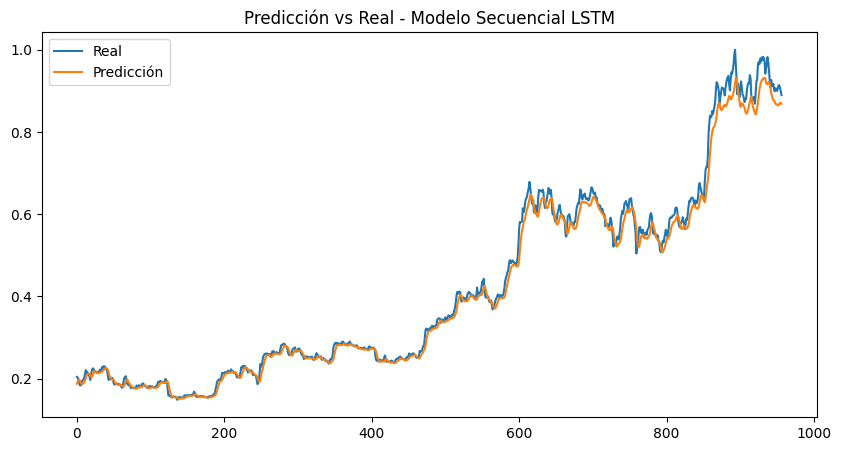

In [30]:
# Entrenamiento y evaluación de un ejemplo
# Ejemplo: modelo secuencial LSTM con 1 capa, 50 neuronas, usando RMSprop
model_seq = build_sequential_model(model_type='LSTM', n_steps=n_steps, n_features=1,
                                   n_units=50, n_layers=1, optimizer='rmsprop')
history_seq = model_seq.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1, verbose=0)

# Predicción y evaluación
predictions = model_seq.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE modelo secuencial LSTM:", mse)

# Visualización
plt.figure(figsize=(10,5))
plt.plot(y_test, label='Real')
plt.plot(predictions, label='Predicción')
plt.title("Predicción vs Real - Modelo Secuencial LSTM")
plt.legend()
plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
MSE modelo funcional GRU: 9.52017271542344e-05


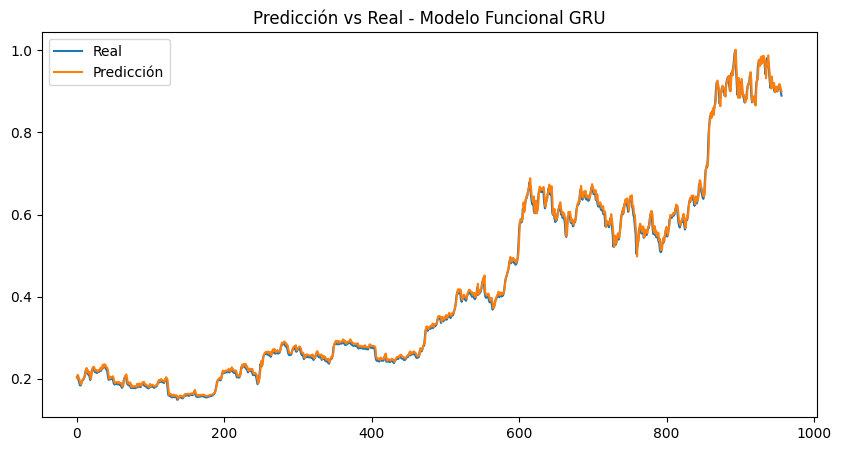

In [32]:
# Por ejemplo, construir un modelo funcional con GRU:
model_func = build_functional_model(model_type='GRU', n_steps=n_steps, n_features=1,
                                    n_units=50, n_layers=1, optimizer='adam')
history_func = model_func.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1, verbose=0)

predictions_func = model_func.predict(X_test)
mse_func = mean_squared_error(y_test, predictions_func)
print("MSE modelo funcional GRU:", mse_func)

plt.figure(figsize=(10,5))
plt.plot(y_test, label='Real')
plt.plot(predictions_func, label='Predicción')
plt.title("Predicción vs Real - Modelo Funcional GRU")
plt.legend()
plt.show()